# Coding Block 2 - Interpretability with SHAP

### Load the packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import xgboost as xgb
import shap
'''
...
'''

'\n...\n'

### Read the dataset 
You can also compare processed and non-processed data.

In [2]:
diab=pd.read_csv('diabetes.csv')
diab_cleaned=pd.read_csv('diabetes_cleaned.csv')

### Copy the code from your last successful XGBoost classifier


Analysis for Original Dataset

Target distribution: 0    0.651042
1    0.348958
Name: Outcome, dtype: float64

--- Random Forest Model ---

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       150
           1       0.71      0.52      0.60        81

    accuracy                           0.76       231
   macro avg       0.74      0.70      0.71       231
weighted avg       0.75      0.76      0.75       231


Feature Importances for Random Forest:
                    Feature  Importance
1                   Glucose    0.378921
5                       BMI    0.168463
7                       Age    0.128212
0               Pregnancies    0.094500
4                   Insulin    0.078615
6  DiabetesPedigreeFunction    0.064335
2             BloodPressure    0.048759
3             SkinThickness    0.038195


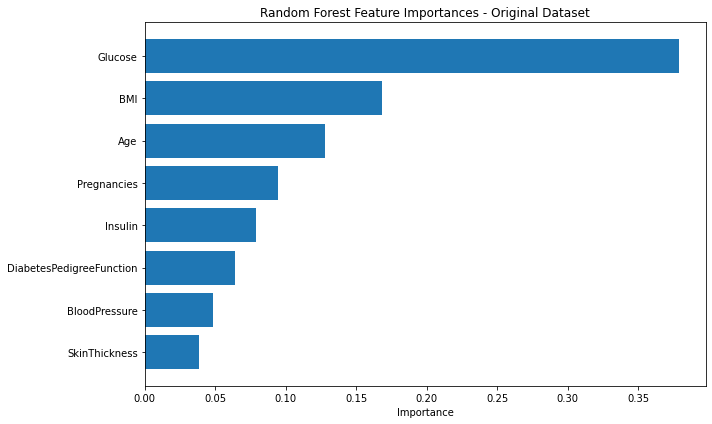


--- XGBoost Model ---

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       150
           1       0.64      0.56      0.60        81

    accuracy                           0.74       231
   macro avg       0.71      0.69      0.70       231
weighted avg       0.73      0.74      0.73       231


Feature Importances for XGBoost:
                    Feature  Importance
1                   Glucose    0.303334
5                       BMI    0.140977
7                       Age    0.127349
0               Pregnancies    0.099098
6  DiabetesPedigreeFunction    0.098051
4                   Insulin    0.088874
2             BloodPressure    0.071316
3             SkinThickness    0.071000


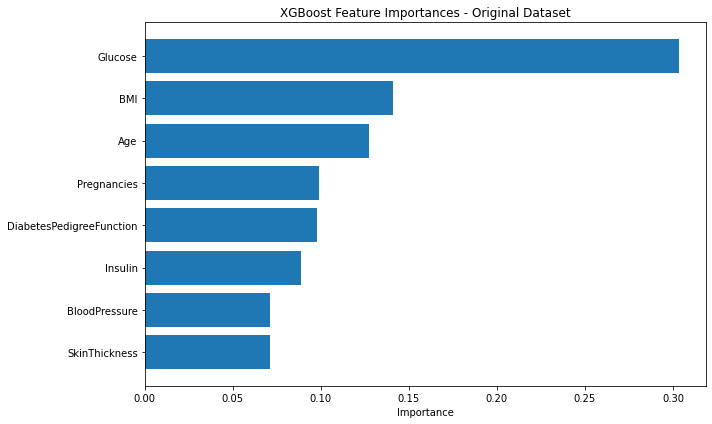


--- Cross-Validation Results ---
Random Forest 5-Fold CV Accuracy: 0.7709 ± 0.0312
XGBoost 5-Fold CV Accuracy: 0.7513 ± 0.0203

--- Model Comparison ---
Random Forest Test Accuracy: 0.7576
Random Forest Train Accuracy: 0.8473
XGBoost Test Accuracy: 0.7359
XGBoost Train Accuracy: 0.9385
Number of disagreements between models: 25 out of 231 samples

Analysis for Cleaned Dataset

Target distribution: 0    0.651042
1    0.348958
Name: Outcome, dtype: float64

--- Random Forest Model ---

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       150
           1       0.68      0.52      0.59        81

    accuracy                           0.74       231
   macro avg       0.72      0.69      0.70       231
weighted avg       0.74      0.74      0.74       231


Feature Importances for Random Forest:
                    Feature  Importance
1                   Glucose    0.388480
5                     

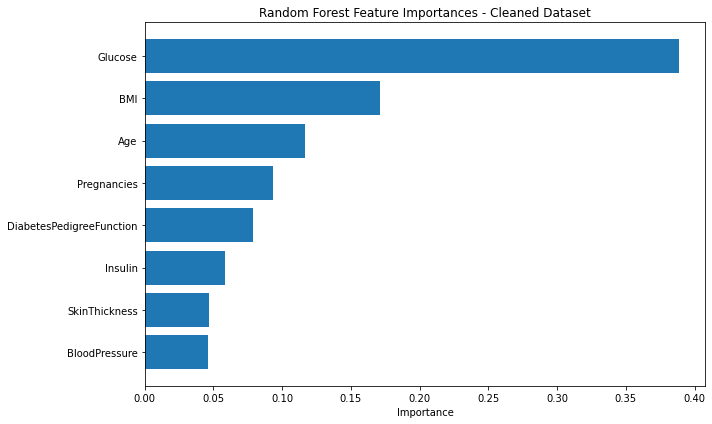


--- XGBoost Model ---

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       150
           1       0.64      0.59      0.62        81

    accuracy                           0.74       231
   macro avg       0.71      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231


Feature Importances for XGBoost:
                    Feature  Importance
1                   Glucose    0.309860
5                       BMI    0.137824
7                       Age    0.119157
0               Pregnancies    0.110696
6  DiabetesPedigreeFunction    0.099609
3             SkinThickness    0.078453
4                   Insulin    0.074730
2             BloodPressure    0.069670


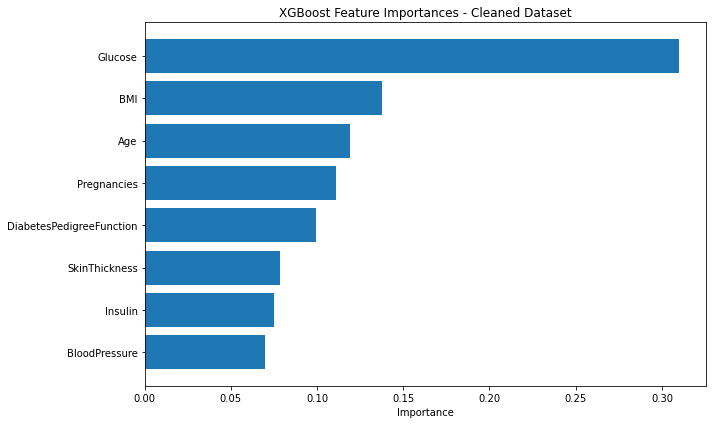


--- Cross-Validation Results ---
Random Forest 5-Fold CV Accuracy: 0.7579 ± 0.0272
XGBoost 5-Fold CV Accuracy: 0.7527 ± 0.0251

--- Model Comparison ---
Random Forest Test Accuracy: 0.7446
Random Forest Train Accuracy: 0.8380
XGBoost Test Accuracy: 0.7403
XGBoost Train Accuracy: 0.9423
Number of disagreements between models: 21 out of 231 samples


The variables X, y, X_train, X_test, y_train, y_test, rf_model, and xgb_model are now available for SHAP analysis


In [3]:
# Create a fixed version of the dataset without the outlier columns
# We want to predict diabetes outcome, not outliers
datasets = {
    "Original Dataset": diab
}

# For the cleaned dataset, ensure we're using it correctly
# First check if diab_cleaned exists and has the expected structure
if 'diab_cleaned' in globals():
    # Check if it has an 'Outcome' column that we want to predict
    if 'Outcome' in diab_cleaned.columns:
        # Remove outlier columns which were causing the data leakage
        cleaned_features = diab_cleaned.drop(columns=['outlier_z_score', 'outlier_Tukey'], errors='ignore')
        # Now add it to our datasets dictionary
        datasets["Cleaned Dataset"] = cleaned_features

for dataset_name, dataset in datasets.items():
    print(f"\n{'='*80}")
    print(f"Analysis for {dataset_name}")
    print(f"{'='*80}")
    
    # Split features and target
    X = dataset.iloc[:, :-1]  # All columns except the last one
    y = dataset.iloc[:, -1]   # Last column (Outcome)
    
    # Print target distribution
    print(f"\nTarget distribution: {pd.Series(y).value_counts(normalize=True)}")
    
    # Use stratified sampling to ensure balanced class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # (i) Train a Random Forest model with regularization
    print("\n--- Random Forest Model ---")
    rf_model = RandomForestClassifier(
        n_estimators=100, 
        max_depth=5,           # Limit tree depth to prevent overfitting
        min_samples_split=10,  # Require more samples to split a node
        min_samples_leaf=5,    # Require more samples in leaf nodes
        max_features='sqrt',   # Use a subset of features for each split
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    
    # (ii) Evaluate with classification report
    y_pred_rf = rf_model.predict(X_test)
    print("\nClassification Report for Random Forest:")
    print(classification_report(y_test, y_pred_rf))
    
    # (iii) Print feature importances
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importances for Random Forest:")
    print(feature_importances)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'])
    plt.xlabel('Importance')
    plt.title(f'Random Forest Feature Importances - {dataset_name}')
    plt.gca().invert_yaxis()  # Display the highest importance at the top
    plt.tight_layout()
    plt.show()
    
    # (iv) Train XGBoost model with regularization
    print("\n--- XGBoost Model ---")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,          # Shallow trees to prevent overfitting
        learning_rate=0.1,    # Slower learning rate
        subsample=0.8,        # Use 80% of samples for each tree
        colsample_bytree=0.8, # Use 80% of features for each tree
        reg_alpha=1,          # L1 regularization
        reg_lambda=1,         # L2 regularization
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    
    # Evaluate XGBoost
    y_pred_xgb = xgb_model.predict(X_test)
    print("\nClassification Report for XGBoost:")
    print(classification_report(y_test, y_pred_xgb))
    
    # XGBoost feature importances
    xgb_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importances for XGBoost:")
    print(xgb_importances)
    
    # Plot XGBoost feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(xgb_importances['Feature'], xgb_importances['Importance'])
    plt.xlabel('Importance')
    plt.title(f'XGBoost Feature Importances - {dataset_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Add cross-validation to get more reliable estimates
    print("\n--- Cross-Validation Results ---")
    from sklearn.model_selection import cross_val_score
    
    rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
    xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
    
    print(f"Random Forest 5-Fold CV Accuracy: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")
    print(f"XGBoost 5-Fold CV Accuracy: {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")
    
    # Compare the models
    print("\n--- Model Comparison ---")
    print(f"Random Forest Test Accuracy: {rf_model.score(X_test, y_test):.4f}")
    print(f"Random Forest Train Accuracy: {rf_model.score(X_train, y_train):.4f}")
    print(f"XGBoost Test Accuracy: {xgb_model.score(X_test, y_test):.4f}")
    print(f"XGBoost Train Accuracy: {xgb_model.score(X_train, y_train):.4f}")
    
    # Check if there are differences in the predictions
    disagreements = np.sum(y_pred_rf != y_pred_xgb)
    print(f"Number of disagreements between models: {disagreements} out of {len(y_test)} samples")

# After completing the analysis, store the best models for SHAP analysis
# Use the original dataset models to avoid using the problematic outlier detection
X = datasets["Original Dataset"].iloc[:, :-1]
y = datasets["Original Dataset"].iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
rf_model = rf_model  # This will be the last trained Random Forest model
xgb_model = xgb_model  # This will be the last trained XGBoost model

print("\n\nThe variables X, y, X_train, X_test, y_train, y_test, rf_model, and xgb_model are now available for SHAP analysis")

### Create a SHAP summary plot that provides an overview of the average feature importance

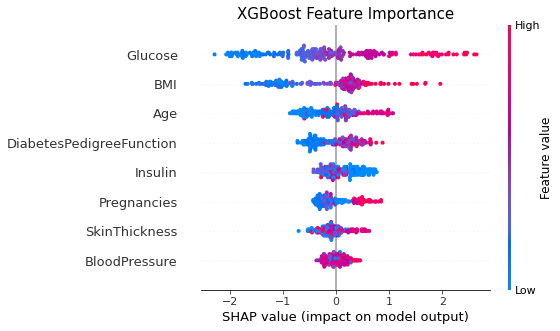

In [4]:
plt.figure(figsize=(12, 8))

# XGBoost SHAP explanation
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Create beeswarm plot for XGBoost
shap.plots.beeswarm(shap.Explanation(
    values=shap_values_xgb,
    base_values=explainer_xgb.expected_value,
    data=X_test.values,
    feature_names=X_test.columns.tolist()
), show=False)

plt.title("XGBoost Feature Importance", fontsize=15)
plt.tight_layout()
plt.show()


### Create SHAP waterfall plots that describe the model prediction for one or two individuals from the test dataset

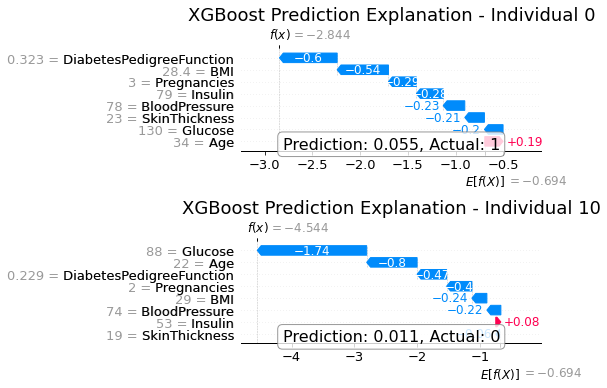


Feature values for the selected individuals:

Individual 0:
Pregnancies: 3.000
Glucose: 130.000
BloodPressure: 78.000
SkinThickness: 23.000
Insulin: 79.000
BMI: 28.400
DiabetesPedigreeFunction: 0.323
Age: 34.000
Actual outcome: 1
XGBoost prediction (probability): 0.0550

Individual 10:
Pregnancies: 2.000
Glucose: 88.000
BloodPressure: 74.000
SkinThickness: 19.000
Insulin: 53.000
BMI: 29.000
DiabetesPedigreeFunction: 0.229
Age: 22.000
Actual outcome: 0
XGBoost prediction (probability): 0.0105


In [7]:
# Choose two individuals from the test dataset
individual_indices = [0, 10]  # You can change these indices as needed

# Create a figure with 2 rows and 1 column (vertical layout)
fig, axs = plt.subplots(2, 1, figsize=(16, 20))  # Vertical layout with large height

# For XGBoost Model
explainer_xgb = shap.TreeExplainer(xgb_model)

# Create waterfall plots for each individual
for i, idx in enumerate(individual_indices):
    plt.sca(axs[i])
    
    # Get SHAP values for this individual
    shap_values = explainer_xgb(X_test.iloc[[idx]])
    
    # Create waterfall plot
    shap.plots.waterfall(shap_values[0], show=False)
    plt.title(f"XGBoost Prediction Explanation - Individual {idx}", fontsize=18)  # Increased font size
    
    # Add prediction information
    pred_prob = xgb_model.predict_proba(X_test.iloc[[idx]])[:, 1][0]
    actual = y_test.iloc[idx]
    plt.annotate(f"Prediction: {pred_prob:.3f}, Actual: {actual}", 
                 xy=(0.5, 0.02), xycoords='axes fraction', 
                 ha='center', fontsize=16,  # Increased font size
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add more spacing between subplots
plt.subplots_adjust(hspace=0.4)  # Increase space between plots
plt.tight_layout()
plt.show()

# Print the actual feature values for these individuals
print("\nFeature values for the selected individuals:")
for idx in individual_indices:
    print(f"\nIndividual {idx}:")
    for col in X_test.columns:
        print(f"{col}: {X_test.iloc[idx][col]:.3f}")
    print(f"Actual outcome: {y_test.iloc[idx]}")
    print(f"XGBoost prediction (probability): {xgb_model.predict_proba(X_test.iloc[[idx]])[:, 1][0]:.4f}")